In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn import preprocessing, metrics
import gc
import os
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from workalendar.usa.texas import Texas
from workalendar.usa.california import California
from workalendar.usa.wisconsin import Wisconsin

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


# function to read the data and merge it (ignoring some columns, this is a very fst model)


def read_data():
    print('Reading files...')
    calendar = pd.read_csv('../input/calendar.csv')
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    sell_prices = pd.read_csv('../input/sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    sales_train_validation = pd.read_csv('../input/sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    submission = pd.read_csv('../input/sample_submission.csv')
    sales_train_evaluation = pd.read_csv("../input/sales_train_evaluation.csv")
    print('Sales train evaluation has {} rows and {} columns'.format(sales_train_evaluation.shape[0], sales_train_evaluation.shape[1]))
    return calendar, sell_prices, sales_train_validation, submission,sales_train_evaluation

In [3]:
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)


In [4]:
## Merging by concat to not lose dtypes
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1

In [5]:
def melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 55000000, merge = False):
    
    # melt sales data, get it ready for training
    sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print('Melted sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    
    
    # seperate test dataframes
    test1_rows = [row for row in submission['id'] if 'validation' in row]
    test2_rows = [row for row in submission['id'] if 'evaluation' in row]
    test1 = submission[submission['id'].isin(test1_rows)]
    test2 = submission[submission['id'].isin(test2_rows)]
    
    # change column names
    test1.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931', 
                      'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939', 'd_1940', 'd_1941']
    test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                      'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']
    
    # get product table
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
    
    # merge with product table
    test2['id'] = test2['id'].str.replace('_evaluation','_validation')
    test1 = test1.merge(product, how = 'left', on = 'id')
    #test2がこれから予測して提出するデータ
    test2 = test2.merge(product, how = 'left', on = 'id')
    test2['id'] = test2['id'].str.replace('_validation','_evaluation')
    
    # 
    test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    sales_train_validation['part'] = 'train'
    test1['part'] = 'test1'
    test2['part'] = 'test2'
    
    data = pd.concat([sales_train_validation, test1, test2], axis = 0)
    
    del sales_train_validation, test1, test2
    
    # get only a sample for fst training
    data = data.loc[nrows:]
    
    # drop some calendar features
    calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
    
    # delete test2 for now
    data = data[data['part'] != 'test2']
    
    if merge:
        # notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)
        data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop(['d'], inplace = True, axis = 1)
        # get the sell price data (this feature should be very important)
        data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
    else: 
        pass
    
    gc.collect()
    
    return data

In [6]:
calendar, sell_prices, sales_train_validation, submission, sales_train_evaluation = read_data()

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns
Sales train evaluation has 30490 rows and 1947 columns


In [7]:
calendar.head(5)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [8]:
sell_prices.head(5)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [9]:
sales_train_validation.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,2,2,0,0,0,1,1,0,2,0,1,1,2,0,1,0,0,0,2,1,0,1,1,2,0,0,0,0,0,0,0,1,0,1,0,1,0,3,1,1,0,1,1,2,0,0,0,0,1,1,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,1,2,2,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1

In [10]:
sales_train_evaluation.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,1,0,1,0,1,0,3,1,1,0,1,1,2,0,0,0,0,1,1,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,1,2,2,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1,0,1,4,0,0,5,0,0,0,0,0,0,2,1,2,1,0,0,0,1,1,1,0,0,1,1,1,1

In [11]:
submission.head(5)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
data = melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 27500000, merge = True)

Melted sales train validation has 58327370 rows and 8 columns
Mem. usage decreased to 3226.27 Mb (9.4% reduction)
Our final dataset to train has 31681090 rows and 19 columns


In [13]:
data.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOUSEHOLD_1_514_WI_3_validation,HOUSEHOLD_1_514,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,16,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,3.500000
1,HOUSEHOLD_1_515_WI_3_validation,HOUSEHOLD_1_515,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,2.470703
2,HOUSEHOLD_1_516_WI_3_validation,HOUSEHOLD_1_516,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,1.980469
3,HOUSEHOLD_1_517_WI_3_validation,HOUSEHOLD_1_517,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,0.979980
4,HOUSEHOLD_1_518_WI_3_validation,HOUSEHOLD_1_518,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,0,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,NaN


In [14]:
clustter = pd.read_csv('clustter_df.csv')
clustter.head(5)

,item_id,clustter
0,FOODS_1_001,5
1,FOODS_1_002,4
2,FOODS_1_003,2
3,FOODS_1_004,1
4,FOODS_1_005,4


In [15]:
clustter_dict  = clustter.set_index('item_id').T.loc['clustter']

data['clustter'] = data.item_id.map(clustter_dict)


del clustter
gc.collect()

60

In [16]:
data.clustter.nunique()

9

In [17]:
first_sell_df = data[data.demand > 0]

first_sell_df = first_sell_df.groupby(['item_id','store_id'])['wm_yr_wk'].min().reset_index()
first_sell_df.columns = ['item_id', 'store_id', 'release']

data = pd.merge(data, first_sell_df, on=['item_id','store_id'], how='left')
data.release = data.release.fillna(0).astype(np.int16)
del first_sell_df
gc.collect()

0

In [18]:
data.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,clustter,release
0,HOUSEHOLD_1_514_WI_3_validation,HOUSEHOLD_1_514,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,16,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,3.500000,8,11325
1,HOUSEHOLD_1_515_WI_3_validation,HOUSEHOLD_1_515,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,2.470703,4,11325
2,HOUSEHOLD_1_516_WI_3_validation,HOUSEHOLD_1_516,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,1.980469,4,11325
3,HOUSEHOLD_1_517_WI_3_validation,HOUSEHOLD_1_517,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,0.979980,6,11325
4,HOUSEHOLD_1_518_WI_3_validation,HOUSEHOLD_1_518,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,0,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,NaN,7,11353


In [19]:
%%time

# Let's check again memory usage
print("{:>20}: {:>8}".format('Original grid_df',sizeof_fmt(data.memory_usage(index=True).sum())))

data = data[data.wm_yr_wk >= data.release] 
data['cum_day'] = data['day'].apply(lambda x:x[2:]).astype(np.int16)

gc.collect()


# Let's check again memory usage
print("{:>20}: {:>8}".format('Reduced grid_df',sizeof_fmt(data.memory_usage(index=True).sum())))

    Original grid_df:   4.0GiB
     Reduced grid_df:   3.8GiB
CPU times: user 17.5 s, sys: 9.02 s, total: 26.5 s
Wall time: 26.5 s


In [20]:
data.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,clustter,release,cum_day
0,HOUSEHOLD_1_514_WI_3_validation,HOUSEHOLD_1_514,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,16,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,3.500000,8,11325,902
1,HOUSEHOLD_1_515_WI_3_validation,HOUSEHOLD_1_515,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,2.470703,4,11325,902
2,HOUSEHOLD_1_516_WI_3_validation,HOUSEHOLD_1_516,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,1.980469,4,11325,902
3,HOUSEHOLD_1_517_WI_3_validation,HOUSEHOLD_1_517,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,0.979980,6,11325,902
6,HOUSEHOLD_1_520_WI_3_validation,HOUSEHOLD_1_520,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,5.480469,7,11325,902


In [21]:
def transform(data):
    
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
        
    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2','is_SNAP']
    states = ['WI','TX','CA']
    data['is_SNAP'] = False
    for state in states:
        data.loc[data.state_id == state, 'is_SNAP'] = data["snap_" + state] == 1
#  その日が祝日かどうかを知るための特徴量---------------------------------------------
    data['date'] = pd.to_datetime(data['date'])
    work_cals = {'CA': California(), 'TX': Texas(), 'WI': Wisconsin()}
    for state, work_cal in work_cals.items():
            data[f'nwd_{state}'] = (~data.date.apply(work_cal.is_working_day))
    data['is_holiday'] = 0
    for state in states:
        data.loc[data.state_id == state, 'is_holiday'] = (data['nwd_' + state] == 1).astype(np.int8)
    data.drop(['nwd_CA','nwd_TX','nwd_WI'], axis=1, inplace=True)
    data.loc[data.is_holiday == 1, 'dayofweek'] = 6
#   ---------------------------------------------------------------------------------------------
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    return data

def simple_fe(data):
    # time features
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['week'] = data['date'].dt.week
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['weekend'] = (data['dayofweek'] == 5.0) | (data['dayofweek'] == 6.0)
    encoder = preprocessing.LabelEncoder()
    data['weekend'] = encoder.fit_transform(data['weekend'])
    data['date_block_num'] = data['month'] + 12 * (data['year'] - 2011)
    data['since_release'] = data['wm_yr_wk']  - data['release']
    data['price_momentum_year'] = data['sell_price']/data.groupby(['item_id','store_id','year'])['sell_price'].transform('mean')
    data['dow_dept'] = data['dayofweek'].astype(str) +"_"+ data['dept_id'].astype(str)
    encoder = preprocessing.LabelEncoder()
    data['dow_dept'] = encoder.fit_transform(data['dow_dept'])
    data['dow_state'] = data['dayofweek'].astype(str) + '_' + data['state_id'].astype(str)
    data['dow_state'] = encoder.fit_transform(data['dow_state'])
    
    
    # rolling demand features
    #testデータは28日間分あるので少なくとも28日遡る。
    data['lag_t28'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    data['lag_t29'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(29))
    data['lag_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(30))
    data['rolling_mean_t7'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    data['rolling_std_t7'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    data['rolling_mean_t14'] = data.groupby(['id'])['demand'].transform(lambda x:x.shift(28).rolling(14).mean())
    data['rolling_mean_t21'] = data.groupby(['id'])['demand'].transform(lambda x:x.shift(28).rolling(21).mean())
    data['rolling_mean_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    data['rolling_mean_t60'] = data.groupby(['id'])['demand'].transform(lambda x:x.shift(28).rolling(30).mean())
    data['rolling_mean_t90'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    data['rolling_mean_t180'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    data['rolling_mean_t360'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(360).mean())
    data['rolling_mean_14_30_rate'] = data['rolling_mean_t14']/(data['rolling_mean_t30'] + 0.01)
    data['rolling_mean_14_60_rate'] = data['rolling_mean_t14']/(data['rolling_mean_t60'] + 0.01)
    data['rolling_mean_14_180_rate'] = data['rolling_mean_t14']/(data['rolling_mean_t180'] + 0.01)
    data['rolling_mean_21_90_rate'] = data['rolling_mean_t21']/(data['rolling_mean_t90'] + 0.01)
    data['rolling_mean_21_180_rate'] = data['rolling_mean_t21']/(data['rolling_mean_t180'] + 0.01)
    data['rolling_std_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
    data['rolling_skew_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).skew())
    data['rolling_kurt_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).kurt())
    data['mean_store'] = data.groupby(['store_id'])['demand'].transform('mean').astype(np.float16)
    data['mean_dept'] = data.groupby(['dept_id'])['demand'].transform('mean').astype(np.float16)
    data['mean_dow'] = data.groupby(['dayofweek'])['demand'].transform('mean').astype(np.float16)
    data['mean_dow_dept'] = data.groupby(['dow_dept'])['demand'].transform('mean').astype(np.float16)
    data['mean_state'] = data.groupby(['state_id'])['demand'].transform('mean').astype(np.float16)
    
    
    # price features
    data['rolling_price_max_t365'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max())
    data['sell_price_norm'] = data['sell_price']/data.rolling_price_max_t365
    data['price_change_t365'] = (data['rolling_price_max_t365'] - data['sell_price']) / (data['rolling_price_max_t365'])
    data['price_momentum_mean'] = data['sell_price']/data.groupby(['item_id','store_id'])['sell_price'].transform('mean')
#     data['price_max_dept'] = data.groupby(['dept_id'])['sell_price'].transform('max')
#     data['sell_price_norm_dept'] = data['sell_price']/data['price_max_dept']
    data['price_std_store'] = data.groupby(['store_id','date_block_num'])['sell_price'].transform('std')
    data['price_std_cat'] = data.groupby(['cat_id','date_block_num'])['sell_price'].transform('std')
    data['rolling_price_std_t30'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
    data.drop(['rolling_price_max_t365'], inplace = True, axis = 1)

    

    return data



In [22]:
# define list of features
features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'year', 'month', 'week', 'dayofweek','is_holiday','day','weekend','date_block_num','since_release', 'event_name_1', 'event_type_1', 
            'dow_state', 'is_SNAP','sell_price', 'lag_t28', 'lag_t29', 'lag_t30', 'rolling_mean_t7', 'rolling_std_t7','rolling_mean_t14','rolling_mean_t21', 'rolling_mean_t30', 'rolling_mean_t60','rolling_mean_t90', 
            'rolling_mean_t180', 'rolling_mean_t360','rolling_std_t30','sell_price_norm','price_change_t365', 'rolling_price_std_t30', 'rolling_skew_t30', 
            'rolling_kurt_t30','price_momentum_mean','price_momentum_year',
           'rolling_mean_14_30_rate','rolling_mean_14_60_rate','rolling_mean_14_180_rate','rolling_mean_21_90_rate','rolling_mean_21_180_rate','dow_dept',
           'price_std_store','price_std_cat','mean_store','mean_state','mean_dept','mean_dow','mean_dow_dept']
#  'event_name_2', 'event_type_2'を消去した。

In [23]:
data.tail(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,clustter,release,cum_day
31681085,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,2.980469,0,11341,1941
31681086,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,2.480469,4,11325,1941
31681087,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,3.980469,7,11325,1941
31681088,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,1.280273,8,11331,1941
31681089,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1941,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,1.000000,7,11405,1941


In [24]:
def find_last_sale(df, n_day):
    ls_df = df[['id', "cum_day", 'demand']]
    print(ls_df.shape)
    ls_df['non_zero'] = (ls_df['demand'] > 0).astype(np.int8)
    ls_df['non_zero_lag'] = ls_df.groupby(["id"])['non_zero'].transform(lambda x:x.shift(n_day).rolling(2000,1).sum()).fillna(-1)
    
    temp_df = ls_df[['id','cum_day','non_zero_lag']].drop_duplicates(subset=['id','non_zero_lag'])
    temp_df.columns = ['id','day_min','non_zero_lag']
    ls_df = ls_df.merge(temp_df, on=['id','non_zero_lag'], how='left')
    print(ls_df.shape)
    ls_df['last_sale']=ls_df['cum_day'] - ls_df['day_min']
    return ls_df[['id','cum_day','last_sale']]

In [25]:
def find_last_snap(df, n_day):
    ls_df = df[['id','cum_day','is_SNAP']]
    ls_df['is_SNAP_lag'] = ls_df.groupby(['id'])['is_SNAP'].transform(lambda x:x.shift(n_day).rolling(2000,1).sum()).fillna(-1)
   
    
    temp_df = ls_df[['id','cum_day','is_SNAP_lag']].drop_duplicates(subset=['id','is_SNAP_lag'])
    temp_df.columns = ['id','day_min','is_SNAP_lag']
    ls_df = ls_df.merge(temp_df, on=['id','is_SNAP_lag'], how='left')
    ls_df['last_snap'] = ls_df['cum_day'] - ls_df['day_min']
    return ls_df[['id','cum_day','last_snap']]

In [26]:
%%time

data = transform(data)
data = reduce_mem_usage(data)



Mem. usage decreased to 3184.83 Mb (45.5% reduction)
CPU times: user 9min 39s, sys: 29.8 s, total: 10min 9s
Wall time: 10min 9s


In [27]:
%%time

data = simple_fe(data)
data = reduce_mem_usage(data)

Mem. usage decreased to 5033.63 Mb (50.3% reduction)
CPU times: user 13min 18s, sys: 1min 19s, total: 14min 37s
Wall time: 14min 37s


In [28]:
%%time
data.drop(['snap_CA','snap_TX','snap_WI','cum_day'],axis=1, inplace=True)

CPU times: user 3.77 s, sys: 2.4 s, total: 6.17 s
Wall time: 6.17 s


In [29]:
%%time
store_df = data.groupby(['store_id', 'date_block_num']).\
                                       agg(store_mean_lag1=('demand', 'mean'),store_std_lag1=('demand', 'std'), store_skew_lag1=('demand','skew')).reset_index()

agg_cols = ["mean",'skew', 'std']


tmp_df = data[(data.date_block_num == 64 )&(data.day <= 24)].groupby(['store_id']).\
                agg(store_mean_lag1=('demand', 'mean'),store_std_lag1=('demand', 'std'), store_skew_lag1=('demand','skew')).reset_index()

store_df = reduce_mem_usage(store_df)

for i in tqdm_notebook(range(10)):
    store_df_temp = store_df[store_df.store_id == i].copy()
    for col in agg_cols:
        store_df_temp.loc[(store_df_temp.date_block_num == 64) & (store_df_temp.store_id == i), 'store_{}_lag1'.format(col)]\
                                                = tmp_df.loc[tmp_df.store_id ==i, 'store_{}_lag1'.format(col)].values
    store_df_temp.date_block_num += 1
    for col in agg_cols:
        dict_tmp = store_df_temp[['date_block_num', 'store_{}_lag1'.format(col)]].set_index('date_block_num').T.loc['store_{}_lag1'.format(col)]
        data.loc[data.store_id==i, 'store_{}_lag1'.format(col)] = data.date_block_num.map(dict_tmp)

for col in agg_cols:
    features.append('store_{}_lag1'.format(col))
    
del store_df, store_df_temp, dict_tmp, tmp_df
gc.collect()

Mem. usage decreased to  0.00 Mb (79.3% reduction)



CPU times: user 23.2 s, sys: 7.7 s, total: 30.9 s
Wall time: 30.9 s


3

In [30]:
%%time
cat_df = data.groupby(['cat_id', 'date_block_num']).\
                    agg(cat_mean_lag1=('demand', 'mean'),cat_std_lag1=('demand', 'std'), cat_skew_lag1=('demand','skew')).reset_index()

tmp_df = data[(data.date_block_num == 64 )&(data.day <= 24)].groupby(['cat_id']).\
                agg(cat_mean_lag1=('demand', 'mean'),cat_std_lag1=('demand', 'std'), cat_skew_lag1=('demand','skew')).reset_index()

cat_df = reduce_mem_usage(cat_df)

for i in tqdm_notebook(range(3)):
    cat_df_temp = cat_df[cat_df.cat_id == i].copy()
    for col in agg_cols:
        cat_df_temp.loc[cat_df_temp.date_block_num == 64, 'cat_{}_lag1'.format(col)] = \
                                                                                            tmp_df.loc[tmp_df.cat_id==i,'cat_{}_lag1'.format(col)].values
    cat_df_temp.date_block_num += 1
    for col in agg_cols:
        dict_tmp = cat_df_temp[['date_block_num', 'cat_{}_lag1'.format(col)]].set_index('date_block_num').T.\
                            loc['cat_{}_lag1'.format(col)]
        data.loc[data.cat_id==i, 'cat_{}_lag1'.format(col)] = data.date_block_num.map(dict_tmp)
        

for col in agg_cols:
    features.append('cat_{}_lag1'.format(col))
        
del cat_df, cat_df_temp, dict_tmp, tmp_df
gc.collect()

Mem. usage decreased to  0.00 Mb (77.6% reduction)



CPU times: user 14.6 s, sys: 4.94 s, total: 19.5 s
Wall time: 19.5 s


3

In [31]:
%%time
dow_df = data.groupby(['dayofweek', 'date_block_num']).\
                    agg(dow_mean_lag1=('demand', 'mean'),dow_std_lag1=('demand', 'std'),dow_skew_lag1=('demand','skew')).reset_index()

tmp_df = data[(data.date_block_num == 64 )&(data.day <= 24)].groupby(['dayofweek']).\
                agg(dow_mean_lag1=('demand', 'mean'),dow_std_lag1=('demand', 'std'), dow_skew_lag1=('demand','skew')).reset_index()

dow_df = reduce_mem_usage(dow_df)

for i in tqdm_notebook(range(7)):
    dow_df_temp = dow_df[dow_df.dayofweek == i].copy()
    for col in agg_cols:
        dow_df_temp.loc[dow_df_temp.date_block_num == 64, 'dow_{}_lag1'.format(col)] = \
                                                                                            tmp_df.loc[tmp_df.dayofweek==i,'dow_{}_lag1'.format(col)].values
    dow_df_temp.date_block_num += 1
    for col in agg_cols:
        dict_tmp = dow_df_temp[['date_block_num', 'dow_{}_lag1'.format(col)]].set_index('date_block_num').T.\
                            loc['dow_{}_lag1'.format(col)]
        data.loc[data.dayofweek==i, 'dow_{}_lag1'.format(col)] = data.date_block_num.map(dict_tmp)
        

for col in agg_cols:
    features.append('dow_{}_lag1'.format(col))
        
del dow_df, dow_df_temp, dict_tmp, tmp_df
gc.collect()

Mem. usage decreased to  0.00 Mb (79.0% reduction)



CPU times: user 21.2 s, sys: 8.18 s, total: 29.4 s
Wall time: 29.4 s


3

In [32]:
for col in agg_cols:
    features.append('clustter_{}_lag1'.format(col))

In [33]:
%%time
clustter_df = data.groupby(['clustter', 'date_block_num']).\
                    agg(clustter_mean_lag1=('demand', 'mean'),clustter_std_lag1=('demand', 'std'),clustter_skew_lag1=('demand','skew')).reset_index()

tmp_df = data[(data.date_block_num == 64 )&(data.day <= 24)].groupby(['clustter']).\
                agg(clustter_mean_lag1=('demand', 'mean'),clustter_std_lag1=('demand', 'std'), clustter_skew_lag1=('demand','skew')).reset_index()

clustter_df = reduce_mem_usage(clustter_df)

for i in tqdm_notebook(range(9)):
    clustter_df_temp = clustter_df[clustter_df.clustter == i].copy()
    for col in agg_cols:
        clustter_df_temp.loc[clustter_df_temp.date_block_num == 64, 'clustter_{}_lag1'.format(col)] = \
                                                                                            tmp_df.loc[tmp_df.clustter==i,'clustter_{}_lag1'.format(col)].values
    clustter_df_temp.date_block_num += 1
    for col in agg_cols:
        dict_tmp = clustter_df_temp[['date_block_num', 'clustter_{}_lag1'.format(col)]].set_index('date_block_num').T.\
                            loc['clustter_{}_lag1'.format(col)]
        data.loc[data.clustter==i, 'clustter_{}_lag1'.format(col)] = data.date_block_num.map(dict_tmp)
        

for col in agg_cols:
    features.append('clustter_{}_lag1'.format(col))
    
features.append('clustter')
        
del clustter_df, clustter_df_temp, dict_tmp, tmp_df
gc.collect()

Mem. usage decreased to  0.00 Mb (79.2% reduction)



CPU times: user 28.4 s, sys: 9.85 s, total: 38.3 s
Wall time: 38.3 s


3

In [34]:
# %%time
# dept_df = data.groupby(['dept_id', 'date_block_num']).\
#                     agg(dept_mean_lag1=('demand', 'mean'),dept_std_lag1=('demand', 'std'),dept_skew_lag1=('demand','skew')).reset_index()

# tmp_df = data[(data.date_block_num == 64 )&(data.day <= 24)].groupby(['dept_id']).\
#                 agg(dept_mean_lag1=('demand', 'mean'),dept_std_lag1=('demand', 'std'), dept_skew_lag1=('demand','skew')).reset_index()

# dept_df = reduce_mem_usage(dept_df)

# for i in tqdm_notebook(range(7)):
#     dept_df_temp = dept_df[dept_df.dept_id == i].copy()
#     for col in agg_cols:
#         dept_df_temp.loc[dept_df_temp.date_block_num == 64, 'dept_{}_lag1'.format(col)] = \
#                                                                                             tmp_df.loc[tmp_df.dept_id==i,'dept_{}_lag1'.format(col)].values
#     dept_df_temp.date_block_num += 1
#     for col in agg_cols:
#         dict_tmp = dept_df_temp[['date_block_num', 'dept_{}_lag1'.format(col)]].set_index('date_block_num').T.\
#                             loc['dept_{}_lag1'.format(col)]
#         data.loc[data.dept_id==i, 'dept_{}_lag1'.format(col)] = data.date_block_num.map(dict_tmp)
        

# for col in agg_cols:
#     features.append('dept_{}_lag1'.format(col))
        
# del dept_df, dept_df_temp, dict_tmp, tmp_df
# gc.collect()

In [35]:
data = data[data.date_block_num > 32]
data = reduce_mem_usage(data)

Mem. usage decreased to 4151.70 Mb (32.0% reduction)


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28453396 entries, 1343540 to 31681089
Data columns (total 73 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   id                        object        
 1   item_id                   int16         
 2   dept_id                   int8          
 3   cat_id                    int8          
 4   store_id                  int8          
 5   state_id                  int8          
 6   day                       int8          
 7   demand                    int16         
 8   part                      object        
 9   date                      datetime64[ns]
 10  wm_yr_wk                  int16         
 11  event_name_1              int8          
 12  event_type_1              int8          
 13  event_name_2              int8          
 14  event_type_2              int8          
 15  sell_price                float16       
 16  clustter                  int8          
 17  

In [37]:
data.describe()

,item_id,dept_id,cat_id,store_id,state_id,day,demand,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,sell_price,clustter,release,is_SNAP,is_holiday,dayofweek,year,month,week,weekend,date_block_num,since_release,price_momentum_year,dow_dept,dow_state,lag_t28,lag_t29,lag_t30,rolling_mean_t7,rolling_std_t7,rolling_mean_t14,rolling_mean_t21,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_mean_t360,rolling_mean_14_30_rate,rolling_mean_14_60_rate,rolling_mean_14_180_rate,rolling_mean_21_90_rate,rolling_mean_21_180_rate,rolling_std_t30,rolling_skew_t30,rolling_kurt_t30,mean_store,mean_dept,mean_dow,mean_dow_dept,mean_state,sell_price_norm,price_change_t365,price_momentum_mean,price_std_store,price_std_cat,rolling_price_std_t30,store_mean_lag1,store_skew_lag1,store_std_lag1,cat_mean_lag1,cat_skew_lag1,cat_std_lag1,dow_mean_lag1,dow_skew_lag1,dow_std_lag1,clustter_mean_lag1,clustter_skew_lag1,clustter_std_lag1
count,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,28210231.0,28200947.0,28191015.0,2.815129e+07,2.815129e+07,2.807395e+07,2.790937e+07,2.763499e+07,2.763499e+07,2.580654e+07,2.306714e+07,1.762016e+07,2.763499e+07,2.763499e+07,2.306714e+07,2.580654e+07,2.306714e+07,2.763499e+07,2.480721e+07,2.480721e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,1.827992e+07,1.827992e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.820095e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07,2.845340e+07
mean,1.532005e+03,3.175059e+00,8.782490e-01,4.522096e+00,9.069751e-01,1.563743e+01,1.266338e+00,1.147663e+04,2.874856e+01,3.777350e+00,1.997074e+00,1.997074e+00,NaN,3.768757e+00,1.133777e+04,3.310423e-01,3.206040e-01,3.003772e+00,2.014589e+03,6.447198e+00,2.636842e+01,2.866788e-01,4.951744e+01,1.388615e+02,NaN,2.420147e+01,9.918292e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,8.794933e+02,1.917417e+00,8.926016e-01,2.869335e+00,8.299046e-01,8.765851e+00,3.778724e+00,8.066236e+01,4.900945e+00,7.917568e-01,6.989617e-02,6.989617e-02,0.000000e+00,2.490231e+00,1.005004e+02,4.705883e-01,4.667088e-01,2.001336e+00,8.691839e-01,3.591054e+00,1.575916e+01,4.522102e-01,9.291621e+00,1.249824e+02,0.000000e+00,1.413993e+01,6.061072e+00,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.133200e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000214e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00,3.300000e+01,0.000000e+00,1.216888e-03,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.677734e+00,-2.148438e+00,8.266602e-01,2.377930e-01,1.119141e+00,2.191162e-01,1.183594e+00,3.787994e-03,-3.353516e+00,1.143456e-03,3.328125e+00,1.905273e+00,0.000000e+00,7.246094e-01,5.488281e+00,1.810547e+00,5.571289

In [38]:
del calendar
gc.collect()

20

In [39]:
del sales_train_validation
gc.collect()

20

In [40]:
del sales_train_evaluation
gc.collect()

20

In [41]:
#FEATURES to remove
## These features lead to overfit
## or values not present in test set
# remove_features = ['id','state_id','date']
# １. store_id, 3. state_idの順に消去して訓練し直す。
# features = [col for col in features if col not in remove_features]

In [42]:
features

['item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'year',
 'month',
 'week',
 'dayofweek',
 'is_holiday',
 'day',
 'weekend',
 'date_block_num',
 'since_release',
 'event_name_1',
 'event_type_1',
 'dow_state',
 'is_SNAP',
 'sell_price',
 'lag_t28',
 'lag_t29',
 'lag_t30',
 'rolling_mean_t7',
 'rolling_std_t7',
 'rolling_mean_t14',
 'rolling_mean_t21',
 'rolling_mean_t30',
 'rolling_mean_t60',
 'rolling_mean_t90',
 'rolling_mean_t180',
 'rolling_mean_t360',
 'rolling_std_t30',
 'sell_price_norm',
 'price_change_t365',
 'rolling_price_std_t30',
 'rolling_skew_t30',
 'rolling_kurt_t30',
 'price_momentum_mean',
 'price_momentum_year',
 'rolling_mean_14_30_rate',
 'rolling_mean_14_60_rate',
 'rolling_mean_14_180_rate',
 'rolling_mean_21_90_rate',
 'rolling_mean_21_180_rate',
 'dow_dept',
 'price_std_store',
 'price_std_cat',
 'mean_store',
 'mean_state',
 'mean_dept',
 'mean_dow',
 'mean_dow_dept',
 'store_mean_lag1',
 'store_skew_lag1',
 'store_std_lag1',
 'cat_mean_lag1',
 'c

In [43]:
features = [col for col in features if 'clustter' not in col]
features.append('clustter')

In [44]:
data_columns = [col for col in features if "demand" not in col]


def run_lgb(data):
    
    # going to evaluate with the last 28 days
    x_train = data[data['date'] <= '2016-03-27']
    y_train = x_train['demand']
    x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
    y_val = x_val['demand']
    test = data[(data['date'] > '2016-04-24')]
    del data
    gc.collect()

    # define random hyperparammeters
    params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective': 'regression',
        'n_jobs': -1,
        'seed': 236,
        'learning_rate': 0.1,
        'bagging_fraction': 0.75,
        'bagging_freq': 10, 
        'colsample_bytree': 0.75
    }
    

    lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'verbose': -1,
    } 


    
    X_train_np = x_train[features].values.astype(np.float16)
    X_valid_np = x_val[features].values.astype(np.float16)
    test_np = test[features].values.astype(np.float16)
    del x_train, x_val
    gc.collect()

    train_set = lgb.Dataset(X_train_np, label = y_train, feature_name = features)
    val_set = lgb.Dataset(X_valid_np, label = y_val, feature_name = features)
    
    del X_train_np
    gc.collect()

    model = lgb.train(lgb_params, train_set, num_boost_round = 2500, early_stopping_rounds = 100, valid_sets = [train_set, val_set], verbose_eval = 100)
    val_pred = model.predict(X_valid_np)
    # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),data_columns)), columns=['Value','Feature'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
#     title = "lgbm_importances_model_" + str(i) + ".png"
#     plt.savefig(title)

    val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
    print(f'Our val rmse score is {val_score}')
    del X_valid_np
    gc.collect()
    y_pred = model.predict(test_np)
    test['demand'] = y_pred
    return test

def predict(test, submission):
    predictions = test[['id', 'date', 'demand']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]

    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    final.to_csv('submission.csv', index = False)
    return final


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 2.51152	valid_1's rmse: 2.14923
[200]	training's rmse: 2.37889	valid_1's rmse: 2.11494
[300]	training's rmse: 2.31045	valid_1's rmse: 2.11025
[400]	training's rmse: 2.27115	valid_1's rmse: 2.10905
[500]	training's rmse: 2.23962	valid_1's rmse: 2.10923
Early stopping, best iteration is:
[419]	training's rmse: 2.26491	valid_1's rmse: 2.10832


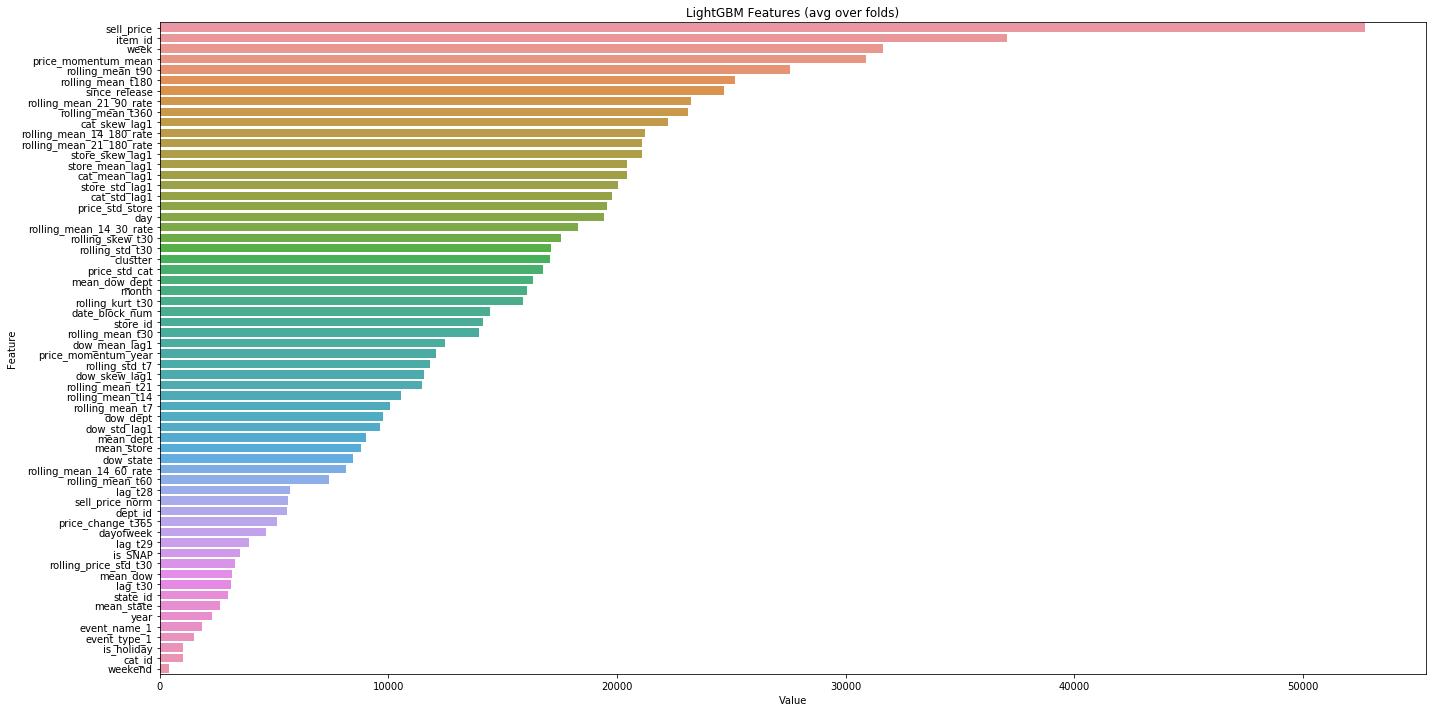

Our val rmse score is 2.108318469850775
CPU times: user 6h 23min 33s, sys: 1min 53s, total: 6h 25min 26s
Wall time: 51min 39s


In [45]:
%%time
data.drop(["part",'release'],axis=1, inplace=True)
gc.collect()



# for i in range(3):
#     state_df = data[data.state_id == i]
#     test_df = run_lgb(state_df)
#     if i == 0:
#         test = test_df 
#     else:
#         test = pd.concat([test, test_df])

test = run_lgb(data)
final = predict(test, submission)

In [46]:
# predict(test,submission)

In [47]:
data[features].head(5)

,item_id,dept_id,cat_id,store_id,state_id,year,month,week,dayofweek,is_holiday,day,weekend,date_block_num,since_release,event_name_1,event_type_1,dow_state,is_SNAP,sell_price,lag_t28,lag_t29,lag_t30,rolling_mean_t7,rolling_std_t7,rolling_mean_t14,rolling_mean_t21,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_mean_t360,rolling_std_t30,sell_price_norm,price_change_t365,rolling_price_std_t30,rolling_skew_t30,rolling_kurt_t30,price_momentum_mean,price_momentum_year,rolling_mean_14_30_rate,rolling_mean_14_60_rate,rolling_mean_14_180_rate,rolling_mean_21_90_rate,rolling_mean_21_180_rate,dow_dept,price_std_store,price_std_cat,mean_store,mean_state,mean_dept,mean_dow,mean_dow_dept,store_mean_lag1,store_skew_lag1,store_std_lag1,cat_mean_lag1,cat_skew_lag1,cat_std_lag1,dow_mean_lag1,dow_skew_lag1,dow_std_lag1,clustter
1343540,1437,3,1,0,0,2013,9,35,6,1,1,1,33,5,30,4,18,1,8.257812,1.0,0.0,2.0,0.428467,0.786621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.999023,1.0,NaN,NaN,NaN,NaN,NaN,45,3.433594,4.925781,1.486328,1.415039,0.789062,1.548828,0.89209,2.111328,16.09375,6.230469,0.790039,8.992188,2.263672,2.130859,15.53125,6.628906,5
1343541,1438,3,1,0,0,2013,9,35,6,1,1,1,33,6,30,4,18,1,3.970703,0.0,0.0,0.0,0.000000,0.000000,0.071411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,45,3.433594,4.925781,1.486328,1.415039,0.789062,1.548828,0.89209,2.111328,16.09375,6.230469,0.790039,8.992188,2.263672,2.130859,15.53125,6.628906,4
1343543,1440,3,1,0,0,2013,9,35,6,1,1,1,33,7,30,4,18,1,4.640625,2.0,2.0,2.0,2.000000,0.577148,1.713867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,45,3.433594,4.925781,1.486328,1.415039,0.789062,1.548828,0.89209,2.111328,16.09375,6.230469,0.790039,8.992188,2.263672,2.130859,15.53125,6.628906,8
1343544,1441,3,1,0,0,2013,9,35,6,1,1,1,33,6,30,4,18,1,3.080078,0.0,1.0,1.0,0.571289,0.534668,0.785645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.043945,1.0,NaN,NaN,NaN,NaN,NaN,45,3.433594,4.925781,1.486328,1.415039,0.789062,1.548828,0.89209,2.111328,16.09375,6.230469,0.790039,8.992188,2.263672,2.130859,15.53125,6.628906,2
1343545,1442,3,1,0,0,2013,9,35,6,1,1,1,33,6,30,4,18,1,1.000000,3.0,1.0,1.0,1.571289,1.397461,1.213867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.013672,1.0,NaN,NaN,NaN,NaN,NaN,45,3.433594,4.925781,1.486328,1.415039,0.789062,1.548828,0.89209,2.111328,16.09375,6.230469,0.790039,8.992188,2.263672,2.130859,15.53125,6.628906,3


In [48]:
features

['item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'year',
 'month',
 'week',
 'dayofweek',
 'is_holiday',
 'day',
 'weekend',
 'date_block_num',
 'since_release',
 'event_name_1',
 'event_type_1',
 'dow_state',
 'is_SNAP',
 'sell_price',
 'lag_t28',
 'lag_t29',
 'lag_t30',
 'rolling_mean_t7',
 'rolling_std_t7',
 'rolling_mean_t14',
 'rolling_mean_t21',
 'rolling_mean_t30',
 'rolling_mean_t60',
 'rolling_mean_t90',
 'rolling_mean_t180',
 'rolling_mean_t360',
 'rolling_std_t30',
 'sell_price_norm',
 'price_change_t365',
 'rolling_price_std_t30',
 'rolling_skew_t30',
 'rolling_kurt_t30',
 'price_momentum_mean',
 'price_momentum_year',
 'rolling_mean_14_30_rate',
 'rolling_mean_14_60_rate',
 'rolling_mean_14_180_rate',
 'rolling_mean_21_90_rate',
 'rolling_mean_21_180_rate',
 'dow_dept',
 'price_std_store',
 'price_std_cat',
 'mean_store',
 'mean_state',
 'mean_dept',
 'mean_dow',
 'mean_dow_dept',
 'store_mean_lag1',
 'store_skew_lag1',
 'store_std_lag1',
 'cat_mean_lag1',
 'c

In [49]:
data.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,sell_price,clustter,is_SNAP,is_holiday,dayofweek,year,month,week,weekend,date_block_num,since_release,price_momentum_year,dow_dept,dow_state,lag_t28,lag_t29,lag_t30,rolling_mean_t7,rolling_std_t7,rolling_mean_t14,rolling_mean_t21,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_mean_t360,rolling_mean_14_30_rate,rolling_mean_14_60_rate,rolling_mean_14_180_rate,rolling_mean_21_90_rate,rolling_mean_21_180_rate,rolling_std_t30,rolling_skew_t30,rolling_kurt_t30,mean_store,mean_dept,mean_dow,mean_dow_dept,mean_state,sell_price_norm,price_change_t365,price_momentum_mean,price_std_store,price_std_cat,rolling_price_std_t30,store_mean_lag1,store_skew_lag1,store_std_lag1,cat_mean_lag1,cat_skew_lag1,cat_std_lag1,dow_mean_lag1,dow_skew_lag1,dow_std_lag1,clustter_mean_lag1,clustter_skew_lag1,clustter_std_lag1
1343540,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,1,0,2013-09-01,11332,30,4,2,2,8.257812,5,1,1,6,2013,9,35,1,33,5,1.0,45,18,1.0,0.0,2.0,0.428467,0.786621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.486328,0.789062,1.548828,0.89209,1.415039,NaN,NaN,0.999023,3.433594,4.925781,0.0,2.111328,16.09375,6.230469,0.790039,8.992188,2.263672,2.130859,15.53125,6.628906,1.839844,19.968750,4.160156
1343541,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,1,0,2013-09-01,11332,30,4,2,2,3.970703,4,1,1,6,2013,9,35,1,33,6,1.0,45,18,0.0,0.0,0.0,0.000000,0.000000,0.071411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.486328,0.789062,1.548828,0.89209,1.415039,NaN,NaN,1.000000,3.433594,4.925781,0.0,2.111328,16.09375,6.230469,0.790039,8.992188,2.263672,2.130859,15.53125,6.628906,0.844727,5.515625,1.731445
1343543,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,1,1,2013-09-01,11332,30,4,2,2,4.640625,8,1,1,6,2013,9,35,1,33,7,1.0,45,18,2.0,2.0,2.0,2.000000,0.577148,1.713867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.486328,0.789062,1.548828,0.89209,1.415039,NaN,NaN,1.000000,3.433594,4.925781,0.0,2.111328,16.09375,6.230469,0.790039,8.992188,2.263672,2.130859,15.53125,6.628906,3.050781,7.753906,8.085938
1343544,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,1,3,2013-09-01,11332,30,4,2,2,3.080078,2,1,1,6,2013,9,35,1,33,6,1.0,45,18,0.0,1.0,1.0,0.571289,0.534668,0.785645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.486328,0.789062,1.548828,0.89209,1.415039,NaN,NaN,1.043945,3.433594,4.925781,0.0,2.111328,16.09375,6.230469,0.790039,8.992188,2.263672,2.130859,15.53125,6.628906,1.520508,13.976562,5.070312
1343545,HOBBIES_1_006_CA_1_validation,1442,3,1,0,0,1,0,2013-09-01,11332,30,4,2,2,1.000000,3,1,1,6,2013,9,35,1,33,6,1.0,45,18,3.0,1.0,1.0,1.571289,1.397461,1.213867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.486328,0.789062,1.548828,0.89209,1.415039,NaN,NaN,1.013672,3.433594,4.925781,0.0,2.111328,16.09375,6.230469,0.790039,8.992188,2.263672,2.130859,15.53125,6.628906,2.308594,9.960938,6.539062


In [50]:
from typing import Union

class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'cat_id',
            'state_id',
            'dept_id',
            'store_id',
            'item_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm_notebook(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]):
#         assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        group_ids = []
        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            group_ids.append(group_id)
            all_scores.append(lv_scores.sum())

        return group_ids, all_scores

In [51]:
ls ../

input/  protos/


In [52]:
ls ../input/

calendar.csv                sales_train_validation.csv  sell_prices.csv
sales_train_evaluation.csv  sample_submission.csv


In [53]:
## reading data
df_calendar = pd.read_csv("../input/calendar.csv")
df_prices = pd.read_csv("../input/sell_prices.csv")
df_sample_submission = pd.read_csv("../input/sample_submission.csv")
df_sample_submission["order"] = range(df_sample_submission.shape[0])

df_train_full = pd.read_csv("../input/sales_train_evaluation.csv")



df_train = df_train_full.iloc[:, :-28]
df_valid = df_train_full.iloc[:, -28:]

evaluator = WRMSSEEvaluator(df_train, df_valid, df_calendar, df_prices)

In [54]:
final.head(5)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.846414,0.692092,0.682191,0.667759,0.761425,0.894818,0.932533,0.773498,0.794940,0.785601,0.808013,0.895073,1.074853,0.930386,0.802790,0.707143,0.693562,0.701003,0.798388,1.085057,1.025153,0.823499,0.710617,0.678045,0.709259,0.750613,1.010120,0.990108
1,HOBBIES_1_002_CA_1_validation,0.317944,0.284717,0.287117,0.286473,0.368681,0.411764,0.409467,0.279733,0.271115,0.245730,0.226945,0.270865,0.324870,0.278609,0.237233,0.209128,0.201518,0.198749,0.235681,0.288862,0.296401,0.200078,0.186096,0.234560,0.226707,0.259392,0.345363,0.324395
2,HOBBIES_1_003_CA_1_validation,0.417441,0.405144,0.388438,0.395092,0.487319,0.561134,0.591571,0.393801,0.352571,0.335783,0.327036,0.412261,0.504457,0.403376,0.327168,0.286679,0.326925,0.403310,0.508910,0.638278,0.668891,0.543474,0.510301,0.531407,0.512542,0.616442,0.769244,0.788730
3,HOBBIES_1_004_CA_1_validation,1.847794,1.617420,1.611349,1.473455,1.944795,2.256143,2.225961,1.765621,1.617270,1.523101,1.437667,1.803447,2.460456,2.171063,1.882054,1.534200,1.559016,1.492585,1.808224,2.249768,2.450992,1.922497,1.580283,1.488923,1.568671,1.904302,2.446050,2.296629
4,HOBBIES_1_005_CA_1_validation,1.114330,0.954783,1.000920,1.131021,1.170985,1.481724,1.503426,1.224834,1.211637,1.091595,0.959026,1.182498,1.548347,1.192342,1.132532,1.064655,1.029854,1.050579,1.229790,1.503570,1.340494,1.079398,1.015706,1.002817,0.976739,1.163915,1.414977,1.450906


In [55]:
final_id = final.index

In [56]:
final.drop('id',axis=1, inplace=True)

In [57]:
valid_target_columns = df_valid.loc[:, df_valid.columns.str.startswith('d_')].columns.tolist()

In [58]:
## evaluating random submission
groups, scores = evaluator.score(final.values)

score_public_lb = np.mean(scores)
# score_public_rank = get_lb_rank(score_public_lb)

for i in range(len(groups)):
    print(f"Score for group {groups[i]}: {round(scores[i], 5)}")

print(f"\nPublic LB Score: {round(score_public_lb, 5)}")

Score for group all_id: 0.29859
Score for group cat_id: 0.34976
Score for group state_id: 0.36863
Score for group dept_id: 0.43498
Score for group store_id: 0.50259
Score for group item_id: 0.84886
Score for group ['state_id', 'cat_id']: 0.43324
Score for group ['state_id', 'dept_id']: 0.50614
Score for group ['store_id', 'cat_id']: 0.55813
Score for group ['store_id', 'dept_id']: 0.63005
Score for group ['item_id', 'state_id']: 0.84621
Score for group ['item_id', 'store_id']: 0.84224

Public LB Score: 0.55162


In [59]:
data[(data.date_block_num == 64)&(data.day <= 24)].tail(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,sell_price,clustter,is_SNAP,is_holiday,dayofweek,year,month,week,weekend,date_block_num,since_release,price_momentum_year,dow_dept,dow_state,lag_t28,lag_t29,lag_t30,rolling_mean_t7,rolling_std_t7,rolling_mean_t14,rolling_mean_t21,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_mean_t360,rolling_mean_14_30_rate,rolling_mean_14_60_rate,rolling_mean_14_180_rate,rolling_mean_21_90_rate,rolling_mean_21_180_rate,rolling_std_t30,rolling_skew_t30,rolling_kurt_t30,mean_store,mean_dept,mean_dow,mean_dow_dept,mean_state,sell_price_norm,price_change_t365,price_momentum_mean,price_std_store,price_std_cat,rolling_price_std_t30,store_mean_lag1,store_skew_lag1,store_std_lag1,cat_mean_lag1,cat_skew_lag1,cat_std_lag1,dow_mean_lag1,dow_skew_lag1,dow_std_lag1,clustter_mean_lag1,clustter_skew_lag1,clustter_std_lag1
30827365,FOODS_3_823_WI_3_validation,1432,2,0,9,2,24,1,2016-04-24,11613,30,4,2,2,2.980469,0,0,1,6,2016,4,16,1,64,272,1.029297,44,20,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.095215,0.266602,0.266602,0.611328,0.677734,0.600098,0.000000,0.000000,0.000000,0.153320,0.138428,0.583496,2.148438,3.746094,1.088867,2.267578,1.548828,2.785156,1.210938,1.0,0.0,1.065430,3.550781,2.191406,0.000000,1.264648,11.382812,3.808594,1.920898,9.140625,4.652344,1.663086,10.65625,4.382812,0.866699,7.828125,2.097656
30827366,FOODS_3_824_WI_3_validation,1433,2,0,9,2,24,0,2016-04-24,11613,30,4,2,2,2.480469,4,0,1,6,2016,4,16,1,64,288,1.141602,44,20,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1.088867,2.267578,1.548828,2.785156,1.210938,1.0,0.0,1.017578,3.550781,2.191406,0.206665,1.264648,11.382812,3.808594,1.920898,9.140625,4.652344,1.663086,10.65625,4.382812,0.665039,5.589844,1.449219
30827367,FOODS_3_825_WI_3_validation,1434,2,0,9,2,24,0,2016-04-24,11613,30,4,2,2,3.980469,7,0,1,6,2016,4,16,1,64,288,1.000000,44,20,1.0,0.0,2.0,0.714355,0.951172,0.856934,1.047852,1.233398,1.233398,0.899902,0.638672,0.652832,0.689453,0.689453,1.321289,1.151367,1.614258,0.935059,0.038940,-1.018555,1.088867,2.267578,1.548828,2.785156,1.210938,1.0,0.0,1.000000,3.550781,2.191406,0.000000,1.264648,11.382812,3.808594,1.920898,9.140625,4.652344,1.663086,10.65625,4.382812,1.623047,5.957031,3.445312
30827368,FOODS_3_826_WI_3_validation,1435,2,0,9,2,24,3,2016-04-24,11613,30,4,2,2,1.280273,8,0,1,6,2016,4,16,1,64,282,1.000000,44,20,4.0,2.0,1.0,1.571289,1.272461,1.357422,1.095703,1.166992,1.166992,1.188477,1.405273,1.025391,1.153320,1.153320,0.958496,0.913574,0.773926,1.084961,0.687012,0.006901,1.088867,2.267578,1.548828,2.785156,1.210938,1.0,0.0,1.000000,3.550781,2.191406,0.000000,1.264648,11.382812,3.808594,1.920898,9.140625,4.652344,1.663086,10.65625,4.382812,1.784180,6.832031,4.421875
30827369,FOODS_3_827_WI_3_validation,1436,2,0,9,2,24,0,2016-04-24,11613,30,4,2,2,1.000000,7,0,1,6,2016,4,16,1,64,208,1.000000,44,20,5.0,0.0,2.0,2.427734,2.070312,2.285156,1.904297,1.966797,1.966797,1.644531,1.683594,1.780273,1.156250,1.156250,1.349609,1.151367,1.125000,1.771484,0.293213,-1.266602,1.088867,2.267578,1.548828,2.785156,1.210938,1.0,0.0,1.000000,3.550781,2.191406,0.000000,1.264648,11.382812,3.808594,1.920898,9.140625,4.652344,1.663086,10.65625,4.382812,1.623047,5.957031,3.445312


In [60]:
data.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,sell_price,clustter,is_SNAP,is_holiday,dayofweek,year,month,week,weekend,date_block_num,since_release,price_momentum_year,dow_dept,dow_state,lag_t28,lag_t29,lag_t30,rolling_mean_t7,rolling_std_t7,rolling_mean_t14,rolling_mean_t21,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_mean_t360,rolling_mean_14_30_rate,rolling_mean_14_60_rate,rolling_mean_14_180_rate,rolling_mean_21_90_rate,rolling_mean_21_180_rate,rolling_std_t30,rolling_skew_t30,rolling_kurt_t30,mean_store,mean_dept,mean_dow,mean_dow_dept,mean_state,sell_price_norm,price_change_t365,price_momentum_mean,price_std_store,price_std_cat,rolling_price_std_t30,store_mean_lag1,store_skew_lag1,store_std_lag1,cat_mean_lag1,cat_skew_lag1,cat_std_lag1,dow_mean_lag1,dow_skew_lag1,dow_std_lag1,clustter_mean_lag1,clustter_skew_lag1,clustter_std_lag1
1343540,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,1,0,2013-09-01,11332,30,4,2,2,8.257812,5,1,1,6,2013,9,35,1,33,5,1.0,45,18,1.0,0.0,2.0,0.428467,0.786621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.486328,0.789062,1.548828,0.89209,1.415039,NaN,NaN,0.999023,3.433594,4.925781,0.0,2.111328,16.09375,6.230469,0.790039,8.992188,2.263672,2.130859,15.53125,6.628906,1.839844,19.968750,4.160156
1343541,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,1,0,2013-09-01,11332,30,4,2,2,3.970703,4,1,1,6,2013,9,35,1,33,6,1.0,45,18,0.0,0.0,0.0,0.000000,0.000000,0.071411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.486328,0.789062,1.548828,0.89209,1.415039,NaN,NaN,1.000000,3.433594,4.925781,0.0,2.111328,16.09375,6.230469,0.790039,8.992188,2.263672,2.130859,15.53125,6.628906,0.844727,5.515625,1.731445
1343543,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,1,1,2013-09-01,11332,30,4,2,2,4.640625,8,1,1,6,2013,9,35,1,33,7,1.0,45,18,2.0,2.0,2.0,2.000000,0.577148,1.713867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.486328,0.789062,1.548828,0.89209,1.415039,NaN,NaN,1.000000,3.433594,4.925781,0.0,2.111328,16.09375,6.230469,0.790039,8.992188,2.263672,2.130859,15.53125,6.628906,3.050781,7.753906,8.085938
1343544,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,1,3,2013-09-01,11332,30,4,2,2,3.080078,2,1,1,6,2013,9,35,1,33,6,1.0,45,18,0.0,1.0,1.0,0.571289,0.534668,0.785645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.486328,0.789062,1.548828,0.89209,1.415039,NaN,NaN,1.043945,3.433594,4.925781,0.0,2.111328,16.09375,6.230469,0.790039,8.992188,2.263672,2.130859,15.53125,6.628906,1.520508,13.976562,5.070312
1343545,HOBBIES_1_006_CA_1_validation,1442,3,1,0,0,1,0,2013-09-01,11332,30,4,2,2,1.000000,3,1,1,6,2013,9,35,1,33,6,1.0,45,18,3.0,1.0,1.0,1.571289,1.397461,1.213867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.486328,0.789062,1.548828,0.89209,1.415039,NaN,NaN,1.013672,3.433594,4.925781,0.0,2.111328,16.09375,6.230469,0.790039,8.992188,2.263672,2.130859,15.53125,6.628906,2.308594,9.960938,6.539062


In [61]:
features

['item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'year',
 'month',
 'week',
 'dayofweek',
 'is_holiday',
 'day',
 'weekend',
 'date_block_num',
 'since_release',
 'event_name_1',
 'event_type_1',
 'dow_state',
 'is_SNAP',
 'sell_price',
 'lag_t28',
 'lag_t29',
 'lag_t30',
 'rolling_mean_t7',
 'rolling_std_t7',
 'rolling_mean_t14',
 'rolling_mean_t21',
 'rolling_mean_t30',
 'rolling_mean_t60',
 'rolling_mean_t90',
 'rolling_mean_t180',
 'rolling_mean_t360',
 'rolling_std_t30',
 'sell_price_norm',
 'price_change_t365',
 'rolling_price_std_t30',
 'rolling_skew_t30',
 'rolling_kurt_t30',
 'price_momentum_mean',
 'price_momentum_year',
 'rolling_mean_14_30_rate',
 'rolling_mean_14_60_rate',
 'rolling_mean_14_180_rate',
 'rolling_mean_21_90_rate',
 'rolling_mean_21_180_rate',
 'dow_dept',
 'price_std_store',
 'price_std_cat',
 'mean_store',
 'mean_state',
 'mean_dept',
 'mean_dow',
 'mean_dow_dept',
 'store_mean_lag1',
 'store_skew_lag1',
 'store_std_lag1',
 'cat_mean_lag1',
 'c